In [203]:
def xcorr(
    img1: np.ndarray, 
    img2: np.ndarray, 
    use_mask: bool = True, 
    use_threshold: bool = True) -> np.ndarray:

    if img1.data.shape != img2.data.shape:
        err = f"Image 1 {img1.data.shape} and Image 2 {img2.data.shape} need to have the same shape"
        logging.error(err)
        raise ValueError(err)

    if use_mask:
        # Create Fourier Transform WITH Bandpass Filter
        pixelsize_img1 = img1.data.shape
        pixelsize_img2 = img2.data.shape
        img1_mask = masks.create_bandpass_mask(pixelsize_img1, 100, 4, 3)
        img2_mask = masks.create_bandpass_mask(pixelsize_img2, 100, 4, 3)
        img1fft = np.fft.ifftshift(img1_mask * np.fft.fftshift(np.fft.fft2(img1.data)))
        img2fft = np.fft.ifftshift(img2_mask * np.fft.fftshift(np.fft.fft2(img2.data)))
        assert img1_mask is not None, "Mask1 can not be None when using a Mask"
        assert img2_mask is not None, "Mask2 can not be None when using a Mask"

    else:
        # Create Fourier Transform
        img1fft = np.fft.ifftshift(np.fft.fftshift(np.fft.fft2(img1.data)))
        img2fft = np.fft.ifftshift(np.fft.fftshift(np.fft.fft2(img2.data)))

    # Do some shady normalization(?)
    n_pixels1 = img1.data.shape[0] * img1.data.shape[1]
    img1fft[0, 0] = 0
    tmp = img1fft * np. conj(img1fft)
    img1fft = n_pixels1 * img1fft / np.sqrt(tmp.sum())
    

    n_pixels2 = img2.data.shape[0] * img2.data.shape[1]
    img2fft[0, 0] = 0
    tmp = img2fft * np. conj(img2fft)
    img2fft = n_pixels2 * img2fft / np.sqrt(tmp.sum())


    if use_threshold:
        # Create threshold (Otsu's method) in abs Space
        abs1 = np.fft.fftshift(np.fft.ifftshift(np.fft.ifft2(img1fft)))
        abs2 = np.fft.fftshift(np.fft.ifftshift(np.fft.ifft2(img2fft)))
        otsu1 = filters.threshold_otsu(np.abs(abs1))
        otsu2 = filters.threshold_otsu(np.abs(abs2))

        # Create segmented binary Img
        binary1 = (abs1 > otsu1)*1
        binary2 = (abs2 > otsu2)*1
        
        # Back to Fourier Space for cross-correlation
        fft1 = np.fft.ifftshift(np.fft.fftshift(np.fft.fft2(binary1)))
        fft2 = np.fft.ifftshift(np.fft.fftshift(np.fft.fft2(binary2)))

        # Cross-correlate the two images
        corr = np.real(np.fft.fftshift(np.fft.ifft2(fft1 * np.conj(fft2))))

        # Cross-correlation center and shift from center
        maxX, maxY = np.unravel_index(np.argmax(corr), corr.shape)
        cen = np.asarray(corr.shape) / 2
        err = np.array(cen - [maxX, maxY], int)
        valMax = np.amax(corr)
        return corr, err

    else:
        # Cross-correlate the two images
        corr = np.real(np.fft.fftshift(np.fft.ifft2(img1fft * np.conj(img2fft))))
       
        # Cross-correlation center and shift from center
        maxX, maxY = np.unravel_index(np.argmax(corr), corr.shape)
        cen = np.asarray(corr.shape) / 2
        err = np.array(cen - [maxX, maxY], int)
        valMax = np.amax(corr)
        return corr, err

In [4]:
# Create dictionary for IB images, sort by grid position, field with (img stack), and corresponding name/img position
dict1 = {}
dict2 = {}
dict3 = {}
grid_poses = ["000.000", "000.001", "000.002", "001.000", "001.001", "001.002", "002.000", "002.001", "002.002"]
hfws = ["8", "15", "20", "30", "50"]
names = ["base", "diag_down", "diag_up", "start"]

for grid_pos in grid_poses:
    dict1[grid_pos] = {}
    dict2[grid_pos] = {}
    for hfw in hfws:
        dict1[grid_pos][hfw] = {}
        dict2[grid_pos][hfw] = {}
        for name in names:
            fname1 = glob.glob(f"../../mapping_2022-09-27.01-18-18PM/{grid_pos}/{name}*{hfw}*.tif")[0]
            fname2 = glob.glob(f"../../mapping_2022-09-27.02-59-50PM/{grid_pos}/{name}*{hfw}*.tif")[0]
    
            img1 = mpimg.imread(fname1)
            img2 = mpimg.imread(fname2)
            dict1[grid_pos][hfw][name] = img1
            dict2[grid_pos][hfw][name] = img2

for grid_pos in ["000.000", "000.001", "001.000", "001.001"]:
    dict3[grid_pos] = {}
    for hfw in hfws:
        dict3[grid_pos][hfw] = {}
        for name in names:
            fname3 = glob.glob(f"../../mapping_2022-09-27.04-26-12PM/{grid_pos}/{name}*{hfw}*.tif")[0]
            img3 = mpimg.imread(fname3)
            dict3[grid_pos][hfw][name] = img3

# Create dictionary for Fluorescence images, sort by grid position (tile) and exposure times
# Additionally, transpose and crop the image array to the right IB image size.
fluor1 = {}
fluor2 = {}
fluor3 = {}
tiles = ["0.0", "0.1", "0.2", "1.0", "1.1", "1.2", "2.0", "2.1", "2.2"]
exposures = ["350", "500"]
for tile in tiles:
    fluor1[tile] = {}
    fluor2[tile] = {}
    for exposure in exposures:
        file1 = glob.glob(f"../../mapping_2022-09-27.01-18-18PM/fluro/{tile}*{exposure}*.tiff")[0]
        file2 = glob.glob(f"../../mapping_2022-09-27.02-59-50PM/fluro/{tile}*{exposure}*.tiff")[0]
        img1 = mpimg.imread(file1)
        img2 = mpimg.imread(file2)
        fluor1[tile][exposure] = np.flip(img1[512:1536, 256:1792], axis=0)
        fluor2[tile][exposure] = np.flip(img2[512:1536, 256:1792], axis=0)

for tile in ["0.0", "0.1", "1.0", "1.1"]:
    fluor3[tile] = {}
    for exposure in exposures:
        file3 = glob.glob(f"../../mapping_2022-09-27.04-26-12PM/fluro/{tile}*{exposure}*.tiff")[0]
        img3 = mpimg.imread(file3)
        fluor3[tile][exposure] = img3.T[512:1536, 256:1792]

FIRST NORMALIZE & THEN MASK 

In [5]:
def normalize(image:np.ndarray) -> np.ndarray:
    mean, std = cv2.meanStdDev(image)
    norm = (image - mean) / std
    zero_array = np.zeros(norm.shape)
    final_img = cv2.normalize(norm,  zero_array, 0, 1, cv2.NORM_MINMAX)
    return final_img


def circ_mask(image:np.ndarray, mask_radius:int):
    zero_array = np.zeros(image.shape)
    mask = cv2.circle(zero_array, (768, 512), mask_radius, (1, 1, 1), -1) 
    smooth_mask = ndi.gaussian_filter(mask, 3)
    masked = image * smooth_mask
    return masked

ROTATIONAL AVERAGE

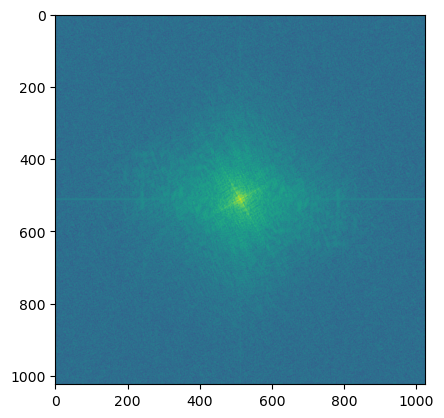

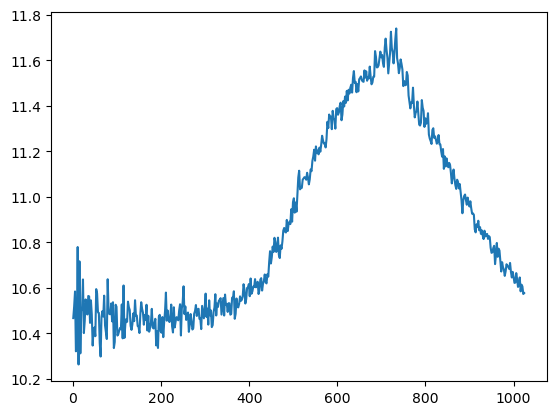

In [6]:
# get some image
image = np.log((np.abs(np.fft.fftshift((np.fft.fft2(fluor2["0.0"]["350"][0:1024, 0:1024]))))))
plt.imshow(image)
plt.show()
# create array of radii
x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
R = np.sqrt(x ** 2 + y ** 2)

# calculate the mean
f = lambda r: image[(R >= r - .5) & (R < r + .5)].mean()
r = np.linspace(1, 1024, num = 512)
mean = np.vectorize(f)(r)

# plot it
fig, ax = plt.subplots()
ax.plot(r, mean)
plt.show()

In [9]:
corr = []
errs = []
for i, j in zip(grid_poses, tiles):
    temp = xcorr(circ_mask(normalize(dict2[i]["50"]["base"]), mask_radius=400), circ_mask(normalize(fluor2[j]["350"]), mask_radius=400), False, False)
    tmp = temp[3]
    corr.append(temp)
    errs.append(tmp)

In [10]:
errs

[array([-53,   6]),
 array([ -6, -47]),
 array([-21, -46]),
 array([ 48, -28]),
 array([ -7, -49]),
 array([-16,  -7]),
 array([58, -2]),
 array([68, -6]),
 array([-37, -45])]

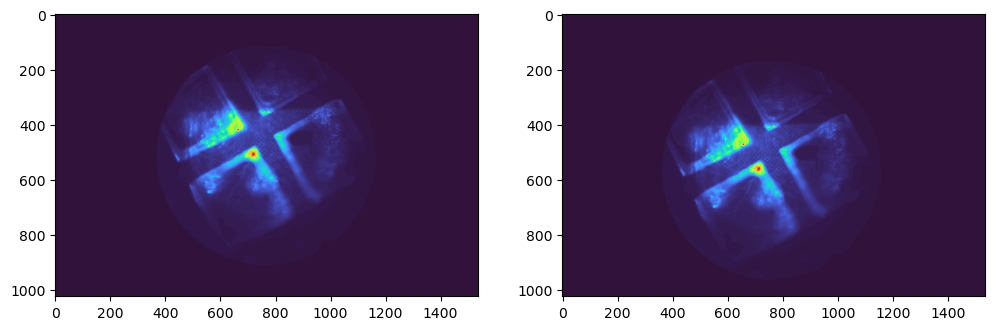

In [11]:
rolled = np.roll(circ_mask(normalize(fluor2["0.0"]["350"]), mask_radius=400), shift=(-errs[0]), axis=(0, 1))
fig, ax = plt.subplots(1,2,figsize=(12,12))
ax[0].imshow(circ_mask(normalize(fluor2["0.0"]["350"]), mask_radius=400), cmap='turbo')
ax[1].imshow(rolled, cmap='turbo')

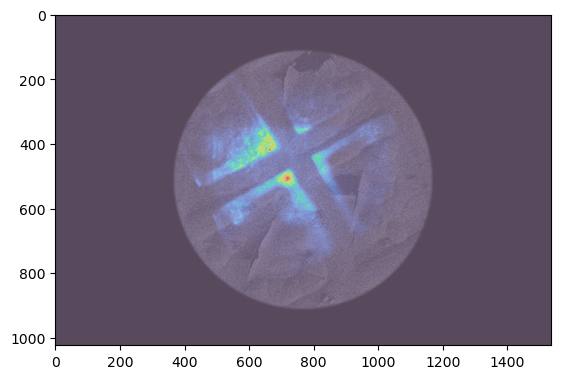

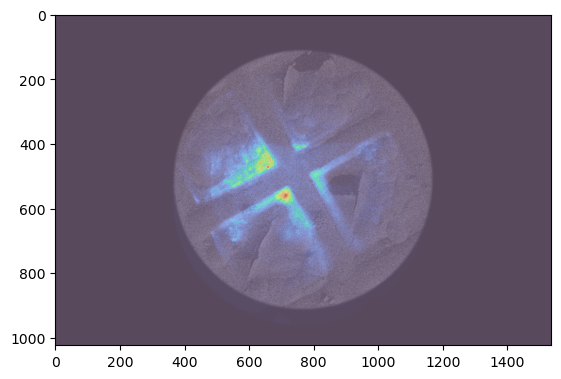

In [12]:
plt.imshow(circ_mask(normalize(dict2["000.000"]["50"]["base"]), mask_radius=400), alpha=0.5, cmap='gray')
plt.imshow(circ_mask(normalize(fluor2["0.0"]["350"]), mask_radius=400), alpha=0.5, cmap='turbo')
plt.show()

plt.imshow(circ_mask(normalize(dict2["000.000"]["50"]["base"]), mask_radius=400), alpha=0.5, cmap='gray')
plt.imshow(rolled, alpha=0.5, cmap='turbo')
plt.show()

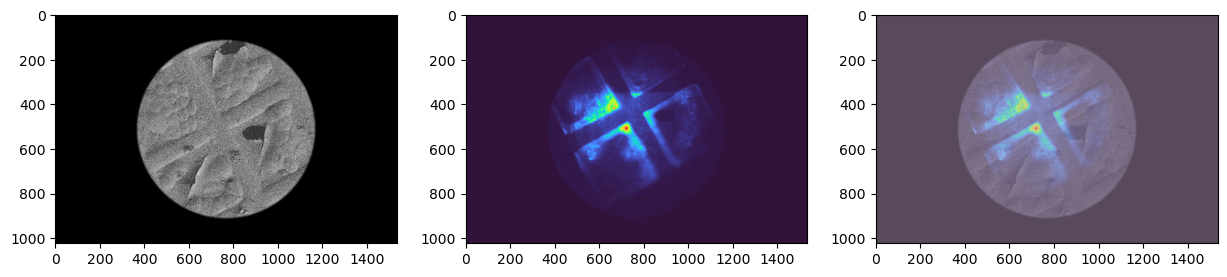

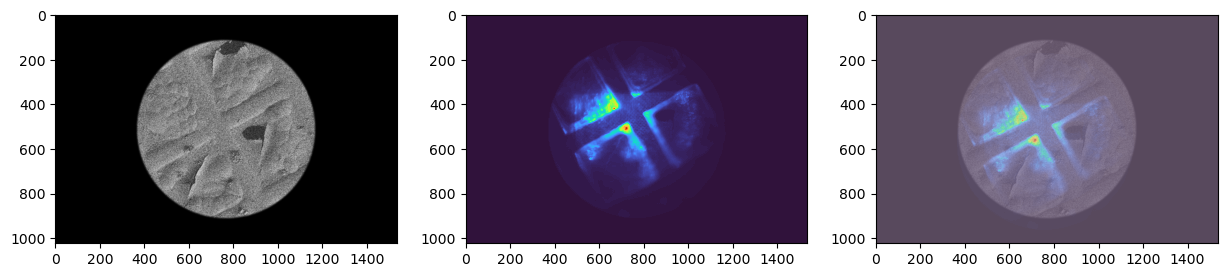

In [13]:
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(circ_mask(normalize(dict2["000.000"]["50"]["base"]), mask_radius=400), cmap='gray')
ax[1].imshow(circ_mask(normalize(fluor2["0.0"]["350"]), mask_radius=400), cmap='turbo')
ax[2].imshow(circ_mask(normalize(dict2["000.000"]["50"]["base"]), mask_radius=400), alpha=0.5, cmap='gray')
ax[2].imshow(circ_mask(normalize(fluor2["0.0"]["350"]), mask_radius=400), alpha=0.5, cmap='turbo')
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(circ_mask(normalize(dict2["000.000"]["50"]["base"]), mask_radius=400), cmap='gray')
ax[1].imshow(circ_mask(normalize(fluor2["0.0"]["350"]), mask_radius=400), cmap='turbo')
ax[2].imshow(circ_mask(normalize(dict2["000.000"]["50"]["base"]), mask_radius=400), alpha=0.5, cmap='gray')
ax[2].imshow(rolled, alpha=0.5, cmap='turbo')


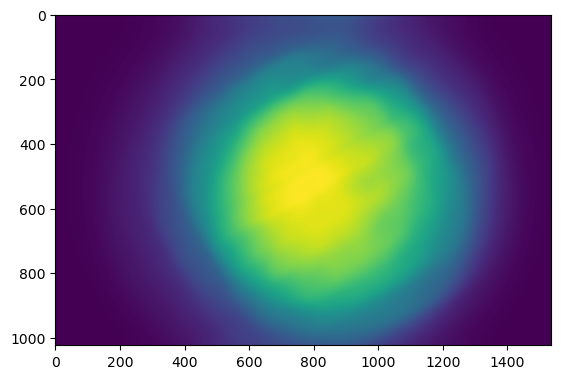

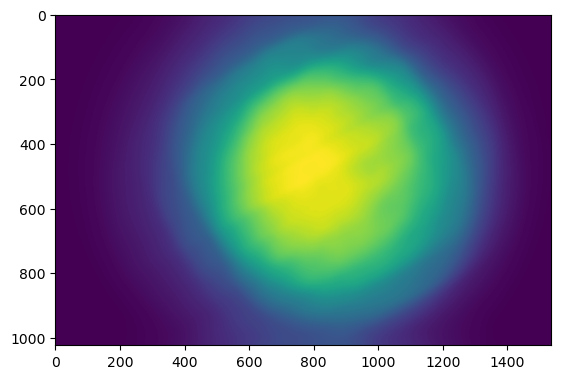

In [14]:
plt.imshow(xcorr(circ_mask(normalize(dict2["000.000"]["50"]["base"]), mask_radius=400), circ_mask(normalize(fluor2["0.0"]["350"]), mask_radius=400), False, False)[0])
plt.show()
plt.imshow(xcorr(circ_mask(normalize(dict2["000.000"]["50"]["base"]), mask_radius=400), rolled, False, False)[0])
plt.show()

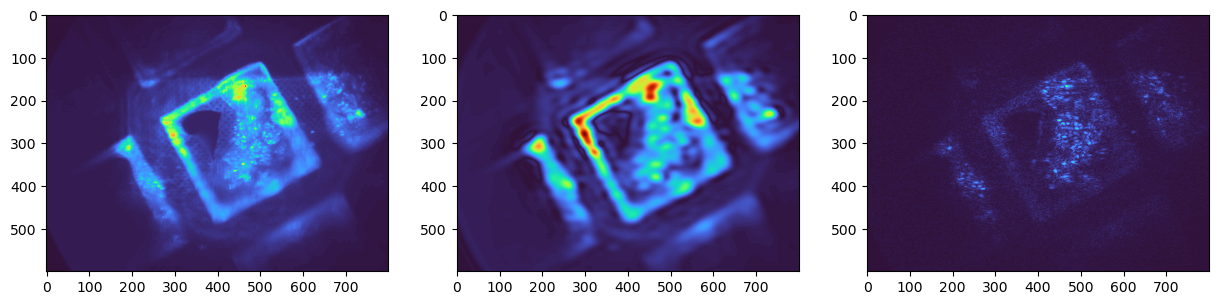

In [147]:
outline_mask = masks.create_bandpass_mask((1024, 1536), 50, 5, 5)
point_mask = masks.create_bandpass_mask((1024, 1536), 500, 300, 5)
temp1 = (outline_mask * np.fft.fftshift(np.fft.fft2(circ_mask(normalize(fluor2["0.1"]["350"]), mask_radius=500))))
temp2 = (point_mask * np.fft.fftshift(np.fft.fft2(circ_mask(normalize(fluor2["0.1"]["350"]), mask_radius=500))))
outline_img = (np.abs(np.fft.ifft2(temp1)))
point_img = (np.abs(np.fft.ifft2(temp2)))
fig, ax = plt.subplots(1,3,figsize=(15,15))
ax[0].imshow(circ_mask(normalize(fluor2["0.1"]["350"]), mask_radius=500)[200:800, 300:1100], cmap='turbo')
ax[1].imshow(outline_img[200:800, 300:1100], cmap='turbo')
ax[2].imshow(point_img[200:800, 300:1100], cmap='turbo')

In [158]:
fl_cropped_normalized = []
ib_cropped_normalized = []
for i,j in zip(grid_poses, tiles):
    temp1 = circ_mask(normalize(fluor2[j]["350"]), mask_radius=500)
    temp2 = circ_mask(normalize(dict2[i]["50"]["base"]), mask_radius=500)
    fl_cropped_normalized.append(temp1[200:800, 400:1100])
    ib_cropped_normalized.append(temp2[200:800, 400:1100])

In [ ]:
names = ["normal_normal", "normal_outline", "normal_point", "outline_normal", "outline_outline", "outline_point"]

normal_normal = xcorr(ib_cropped_normalized[1], fl_cropped_normalized[1], False, False)
normal_outline = xcorr(ib_cropped_normalized[1], fl_outline[1], False, False)
normal_point = xcorr(ib_cropped_normalized[1], fl_point[1], False, False)
outline_normal = xcorr(ib_outline[1], fl_cropped_normalized[1], False, False)
outline_outline = xcorr(ib_outline[1], fl_outline[1], False, False)
outline_point = xcorr(ib_outline[1], fl_point[1], False, False)

In [191]:
outline_mask_crop = masks.create_bandpass_mask((600, 700), 50, 5, 5)
point_mask_crop = masks.create_bandpass_mask((600, 700), 500, 300, 5)
ib_outline = []
ib_point = []
fl_outline = []
fl_point = []
for i in range(9):
    temp1 = (outline_mask_crop * np.fft.fftshift(np.fft.fft2(fl_cropped_normalized[i])))
    temp2 = (point_mask_crop * np.fft.fftshift(np.fft.fft2(fl_cropped_normalized[i])))
    temp3 = (outline_mask_crop * np.fft.fftshift(np.fft.fft2(ib_cropped_normalized[i])))
    temp4 = (point_mask_crop * np.fft.fftshift(np.fft.fft2(ib_cropped_normalized[i])))
    fl_outline.append(np.abs(np.fft.ifft2(temp1)))
    fl_point.append(np.abs(np.fft.ifft2(temp2)))
    ib_outline.append(np.abs(np.fft.ifft2(temp3)))
    ib_point.append(np.abs(np.fft.ifft2(temp4)))

In [ ]:
filter_dict = []
for name, i in zip(names, range(9)):
    corr, err = 

In [193]:
roll = np.roll(fl_cropped_normalized[1], shift=(-normal_normal[3]), axis=(0, 1))

(600, 700)

[293 132]


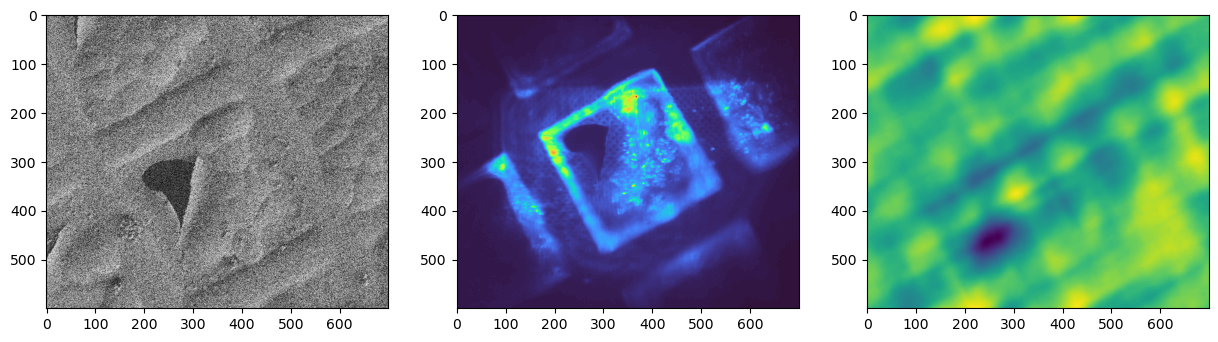

[-66  45]


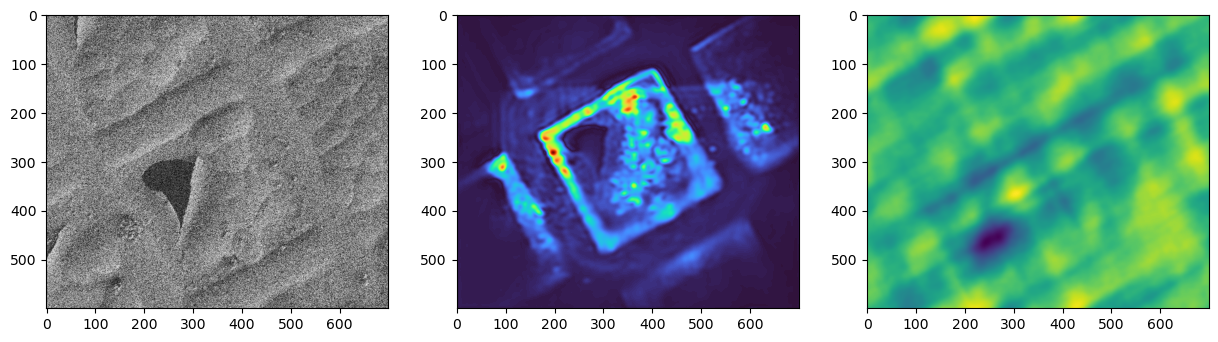

In [202]:
fig, ax = plt.subplots(1,3, figsize=(15,15))
print(normal_normal[3])
ax[0].imshow(ib_cropped_normalized[1], cmap='gray')
ax[1].imshow(fl_cropped_normalized[1], cmap='turbo')
ax[2].imshow(normal_normal[0])
plt.show()

fig, ax = plt.subplots(1,3, figsize=(15,15))
print(normal_outline[3])
ax[0].imshow(ib_cropped_normalized[1], cmap='gray')
ax[1].imshow(fl_outline[1], cmap='turbo')
ax[2].imshow(normal_outline[0])
plt.show()

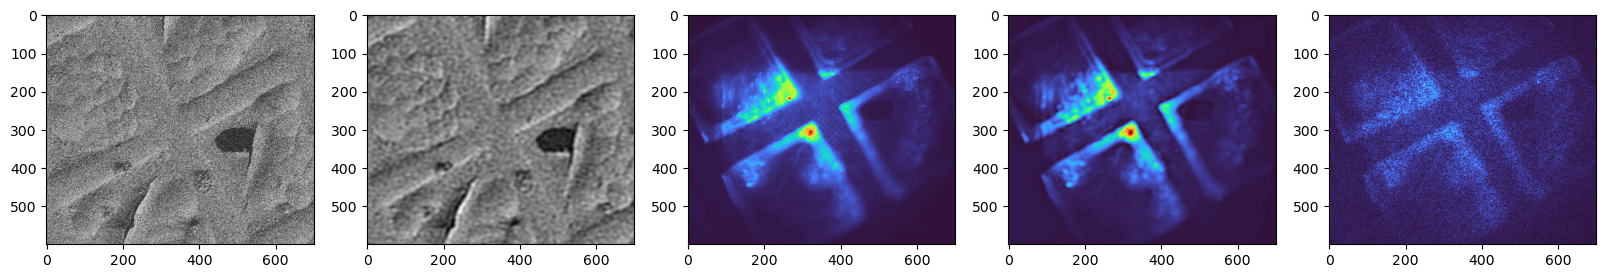

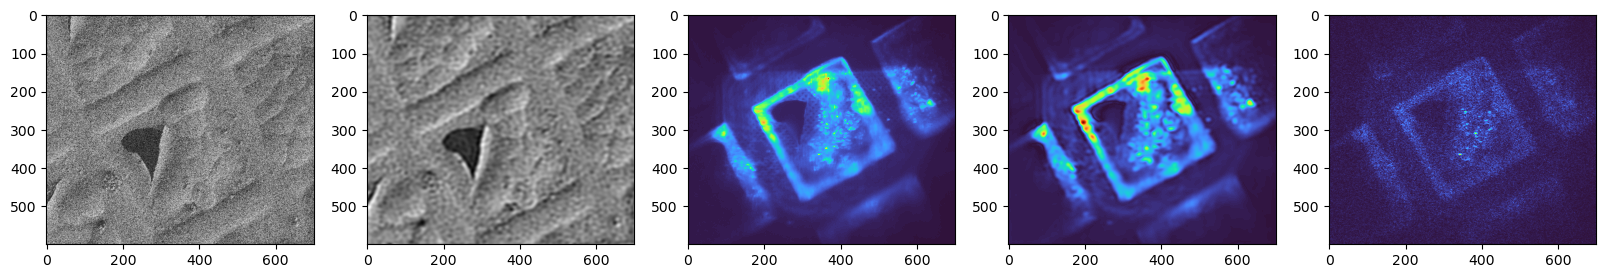

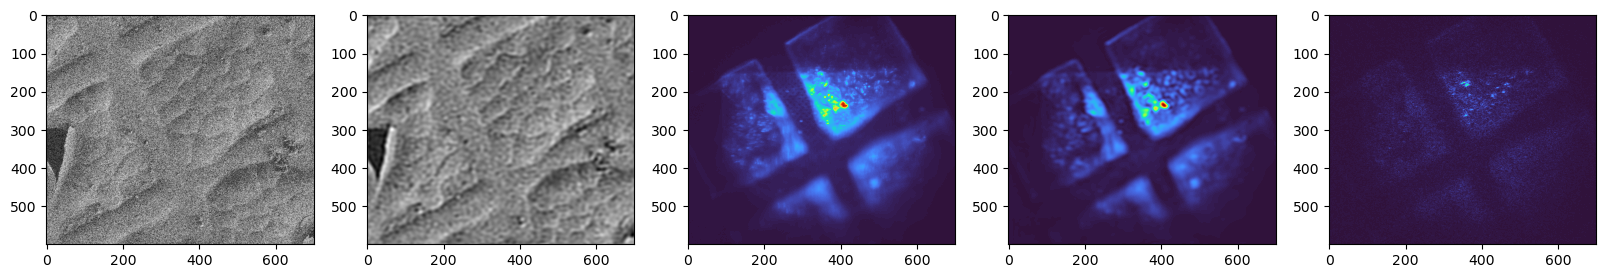

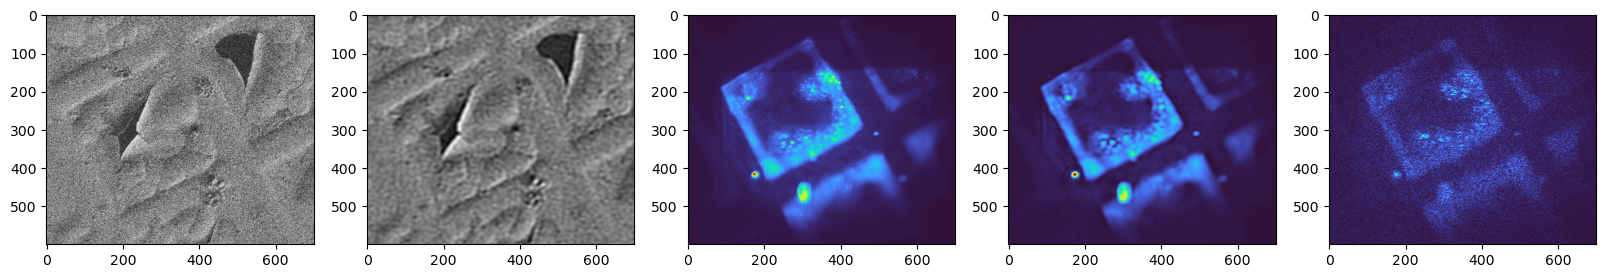

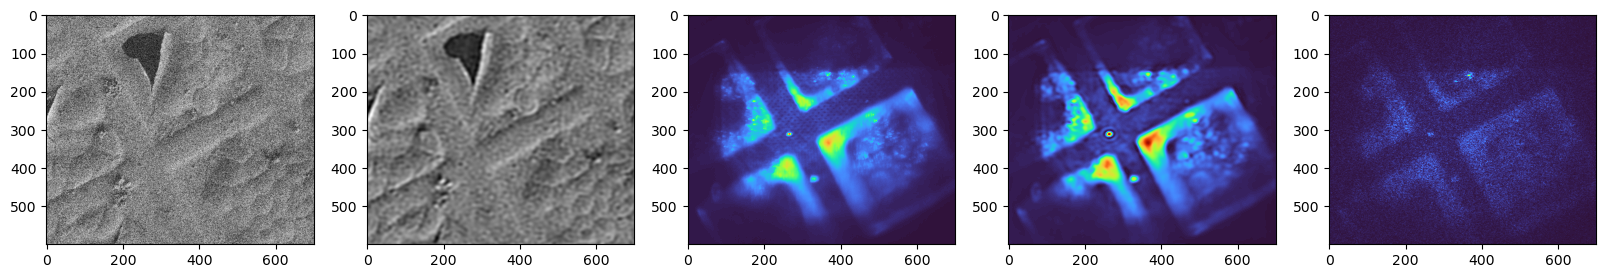

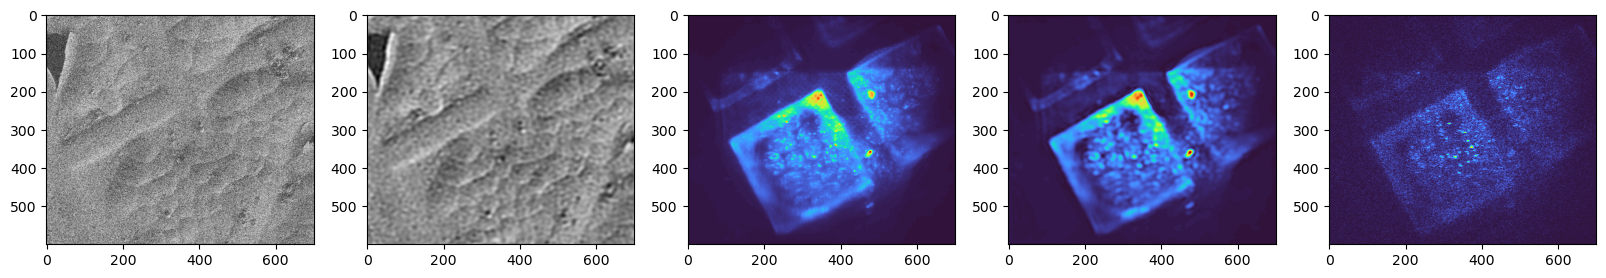

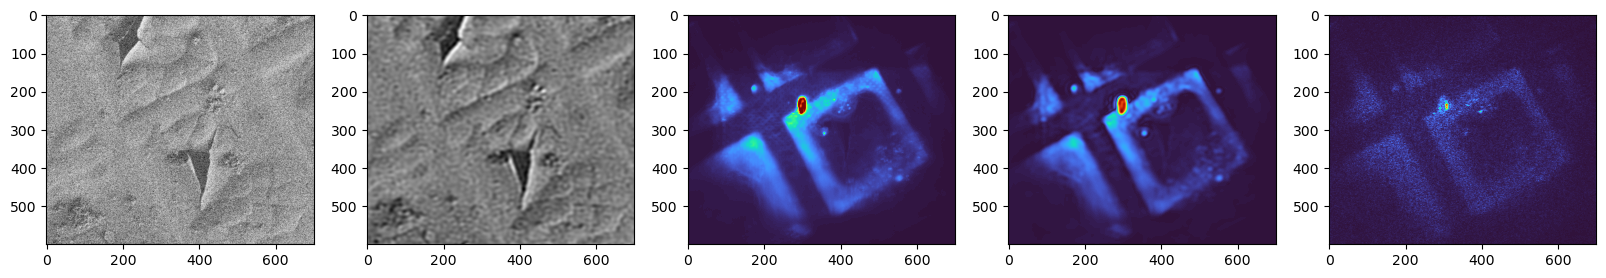

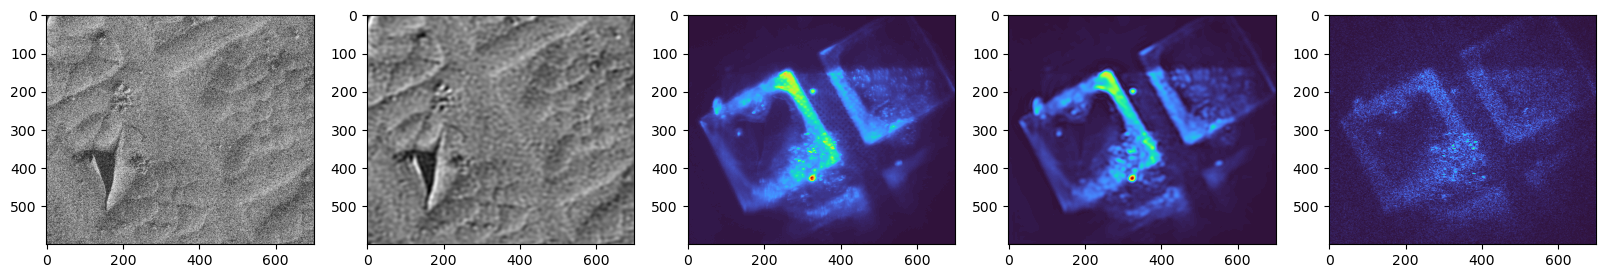

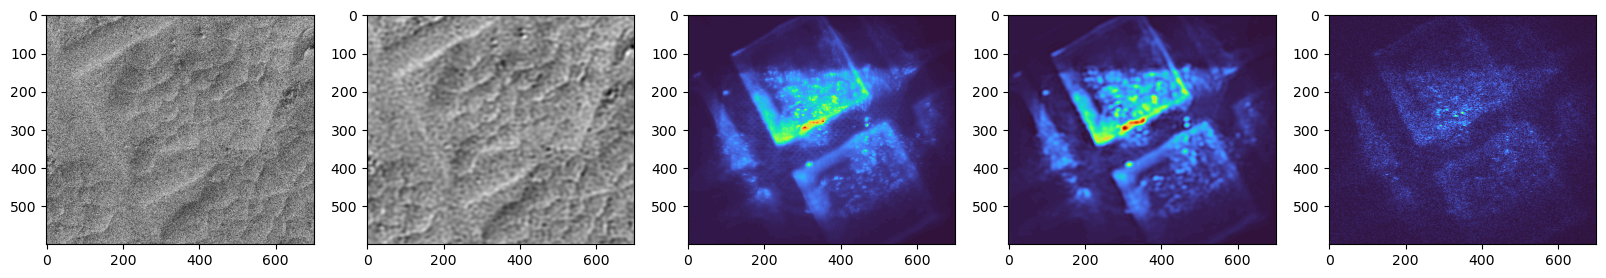

In [169]:
for i in range(9):
    fig, ax = plt.subplots(1,5,figsize=(20,20))
    ax[0].imshow(ib_cropped_normalized[i], cmap='gray')
    ax[1].imshow(ib_outline[i], cmap='gray')
    ax[2].imshow(fl_cropped_normalized[i], cmap='turbo')
    ax[3].imshow(fl_outline[i], cmap='turbo')
    ax[4].imshow(fl_point[i], cmap='turbo')
    plt.show()